## Polytope Climate-DT example notebook

This notebook shows how to use earthkit-data and earthkit-plots to pull destination-earth data from LUMI and plot it using earthkit-plots on a domain.

Before running the notebook you need to set up your credentials. See the main readme of this repository for different ways to do this or use the following cells to authenticate.

You will need to generate your credentials using the desp-authentication.py script.

This can be run as follows:

In [ ]:
%%capture cap
%run ../desp-authentication.py

This will generate a token that can then be used by earthkit and polytope.

In [ ]:
output_1 = cap.stdout.split('}\n')
access_token = output_1[-1][0:-1]

# Requirements
To run this notebook install the following:
* pip install earthkit-data
* pip install earthkit-plots
* pip install earthkit-regrid  (Optional for spectral variables)
* pip install cf-units         (Optional for unit conversion in maps)

If you do not have eccodes installed please install eccodes using conda as it is a dependency of earthkit, or install earthkit via conda

* conda install eccodes -c conda-forge
* conda install earthkit-data -c conda-forge

In [1]:
import earthkit.data
import earthkit.plots
import earthkit.regrid

# This request matches multiple parameter of the climate DT

request = {
    'activity': 'ScenarioMIP',
    'class': 'd1',
    'dataset': 'climate-dt',
    'date': '20200102',
    'experiment': 'SSP3-7.0',
    'expver': '0001',
    'generation': '1',
    'levtype': 'sfc',
    'model': 'IFS-NEMO',
    'param': '134/165/166',
    'realization': '1',
    'resolution': 'standard',
    'stream': 'clte',
    'time': '0100', # '0100/0200/0300/0400/0500/0600'
    'type': 'fc'
}

#data is an earthkit streaming object but with stream=False will download data immediately 
data = earthkit.data.from_source("polytope", "destination-earth", request, address="polytope.lumi.apps.dte.destination-earth.eu", stream=False)


2025-06-03 10:55:40 - INFO - Sending request...
{'request': 'activity: ScenarioMIP\n'
            'class: d1\n'
            'dataset: climate-dt\n'
            "date: '20200102'\n"
            'experiment: SSP3-7.0\n'
            "expver: '0001'\n"
            "generation: '1'\n"
            'levtype: sfc\n'
            'model: IFS-NEMO\n'
            'param: 134/165/166\n'
            "realization: '1'\n"
            'resolution: standard\n'
            'stream: clte\n'
            "time: '0100'\n"
            'type: fc\n',
 'verb': 'retrieve'}
2025-06-03 10:55:41 - INFO - Request accepted. Please poll ./50ee3e10-727c-47b5-89fb-460cba8de502 for status
2025-06-03 10:55:41 - INFO - Checking request status (./50ee3e10-727c-47b5-89fb-460cba8de502)...
2025-06-03 10:55:41 - INFO - The current status of the request is 'queued'
2025-06-03 10:55:41 - INFO - The current status of the request is 'processing'
2025-06-03 10:55:44 - INFO - The current status of the request is 'processed'


In [2]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,sp,surface,0,20200102,100,0,fc,None,healpix
1,ecmf,10u,heightAboveGround,10,20200102,100,0,fc,None,healpix
2,ecmf,10v,heightAboveGround,10,20200102,100,0,fc,None,healpix


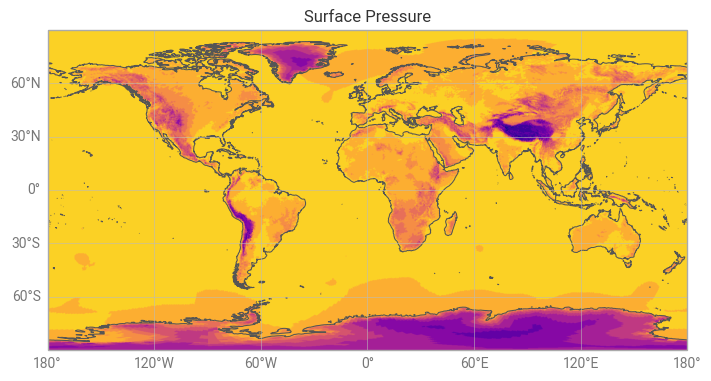

In [3]:
chart = earthkit.plots.Map(extent=[-180, 180, -90, 90])
chart.block(
    data[0]
)

chart.title("Surface Pressure")
chart.coastlines()
chart.gridlines()
chart.show()

In [4]:
# Regrid t=from healpix for conversion to xarray
data_latlon = earthkit.regrid.interpolate(data, out_grid={"grid": [0.1,0.1]}, method="linear")
# Convert data to xarray
data_latlon.to_xarray(engine="cfgrib")

/opt/homebrew/Caskroom/miniforge/base/envs/earthkit/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 78MB
Dimensions:            (time: 1, step: 1, surface: 1, latitude: 1801,
                        longitude: 3600, heightAboveGround: 1)
Coordinates:
  * time               (time) datetime64[ns] 8B 2020-01-02T01:00:00
  * step               (step) timedelta64[ns] 8B 00:00:00
  * surface            (surface) float64 8B 0.0
  * latitude           (latitude) float64 14kB 90.0 89.9 89.8 ... -89.9 -90.0
  * longitude          (longitude) float64 29kB 0.0 0.1 0.2 ... 359.8 359.9
    valid_time         (time, step) datetime64[ns] 8B ...
  * heightAboveGround  (heightAboveGround) float64 8B 10.0
Data variables:
    sp                 (time, step, surface, latitude, longitude) float32 26MB ...
    u10                (time, step, heightAboveGround, latitude, longitude) float32 26MB ...
    v10                (time, step, heightAboveGround, latitude, longitude) float32 26MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          1003
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-03T10:55 GRIB to CDM+CF via cfgrib-0.9.1...

Now we will plot a specific area using earthkit-plots. In this case we will plot the data we have retrieved over Europe.

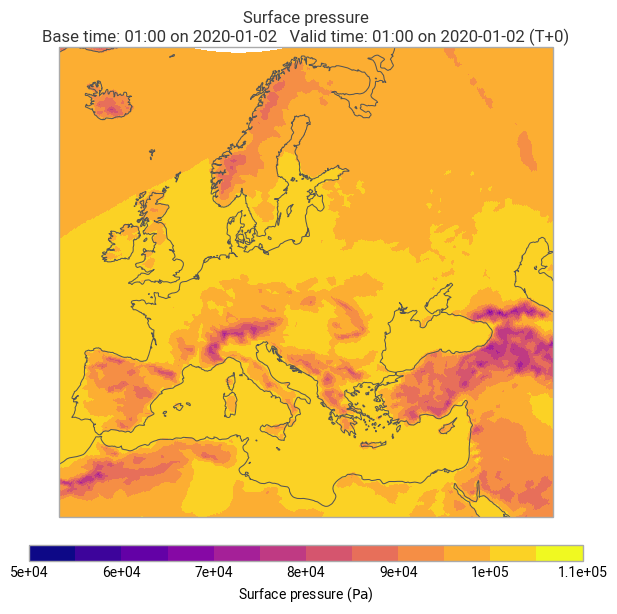

In [7]:
chart = earthkit.plots.Map(domain=["Europe"])

chart.block(data_latlon[0])
chart.title()
chart.legend()

chart.coastlines()

chart.show()

We can plot all the parameters we have as well using earthkit-plots

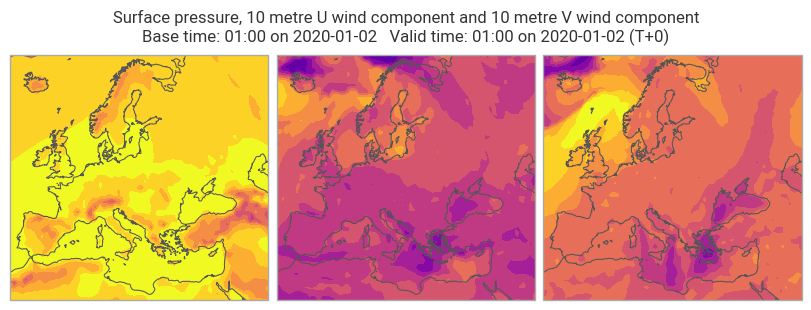

In [22]:
figure = earthkit.plots.Figure(columns=3, size=(8, 3), domain="Europe")

for i, _ in enumerate(range(len(data.ls()))):
      figure.add_map(0, i)
figure.contourf(data)
figure.land()
figure.coastlines()
figure.title()
figure.show()